# 翡翠水庫資料探索與預測

### 資料來源
https://data.gov.tw/dataset/147034

https://data.gov.tw/dataset/145840

## 資料處理

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.simplefilter('ignore')

In [2]:
#匯入資料，日資料

reservoir_Daily = pd.read_csv("reservoir.csv", index_col = 0, parse_dates = True)
#index_col = 0：無index的設定
#parse_dates=True：如果日期欄位在最左側，可以直接將日期讀取為index，並以時間的方式運作
#parse_dates=['date']：如果日期欄位不在最左側，則可以指定欄位

In [3]:
#檢視資料
reservoir_Daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2435 entries, 2015-07-01 to 2022-02-28
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   DailyMeanLevel                        2435 non-null   float64
 1   ReservoirEffectiveStorage             2435 non-null   float64
 2   DailyMeanRainfall                     2435 non-null   float64
 3   Inflow                                2435 non-null   object 
 4   Outflow                               2435 non-null   object 
 5   Netflow                               2435 non-null   object 
 6   NanshiFlow                            2435 non-null   object 
 7   TotalRawWaterVolumeOfNanshiAndBeishi  2435 non-null   object 
dtypes: float64(3), object(5)
memory usage: 171.2+ KB


In [4]:
#整理資料存在字串的欄位
#把上方顯示object的去除commas且轉為integer
reservoir_Daily[reservoir_Daily.columns[3:]] = reservoir_Daily[reservoir_Daily.columns[3:]].replace(',','',regex=True).astype('int64')

In [5]:
#確認資料處理正確
reservoir_Daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2435 entries, 2015-07-01 to 2022-02-28
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   DailyMeanLevel                        2435 non-null   float64
 1   ReservoirEffectiveStorage             2435 non-null   float64
 2   DailyMeanRainfall                     2435 non-null   float64
 3   Inflow                                2435 non-null   int64  
 4   Outflow                               2435 non-null   int64  
 5   Netflow                               2435 non-null   int64  
 6   NanshiFlow                            2435 non-null   int64  
 7   TotalRawWaterVolumeOfNanshiAndBeishi  2435 non-null   int64  
dtypes: float64(3), int64(5)
memory usage: 171.2 KB


In [6]:
#在日資料中生成year這個index
reservoir_Daily["year"] = reservoir_Daily.index.year

In [7]:
#將日資料改月資料
reservoir_Monthly = reservoir_Daily

reservoir_Monthly = reservoir_Monthly.groupby(pd.PeriodIndex(reservoir_Monthly.index, freq = "M"))[reservoir_Monthly.columns].mean()
#reservoir_Monthly = reservoir_Monthly.groupby(pd.PeriodIndex(reservoir_Monthly.Date, freq = "M"))[reservoir_Monthly.columns].mean().reset_index()

#將欄位改名字
reservoir_Monthly = reservoir_Monthly.rename(columns={"DailyMeanLevel": "ResMeanLevel", "DailyMeanRainfall": "MeanRainfall", "ReservoirEffectiveStorage": "ResEffectiveStorage"})

In [8]:
#inedx year需要為整數，以便下方做判斷
reservoir_Monthly["year"] = reservoir_Monthly["year"].astype("int")
reservoir_Monthly.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 80 entries, 2015-07 to 2022-02
Freq: M
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ResMeanLevel                          80 non-null     float64
 1   ResEffectiveStorage                   80 non-null     float64
 2   MeanRainfall                          80 non-null     float64
 3   Inflow                                80 non-null     float64
 4   Outflow                               80 non-null     float64
 5   Netflow                               80 non-null     float64
 6   NanshiFlow                            80 non-null     float64
 7   TotalRawWaterVolumeOfNanshiAndBeishi  80 non-null     float64
 8   year                                  80 non-null     int32  
dtypes: float64(8), int32(1)
memory usage: 5.9 KB


In [9]:
##取出各年度的每月資料

#創立List當中的空間
Yearlist_Monthly = []
CorrList_Monthly = []
for year in range(2015, 2023):
    Yearlist_Monthly = Yearlist_Monthly + ["reservoir_Monthly_" + str(year)]
    CorrList_Monthly = CorrList_Monthly + ["reservoir_Monthly_" + str(year)]
    
#取出個年度的每月資料以及生成該年度變數之間的相關係數
for i, year in zip(range(0, 9), range(2015, 2023)):
    Yearlist_Monthly[i] = reservoir_Monthly[(reservoir_Monthly.year == year)].drop(columns = "year")
    CorrList_Monthly[i] = Yearlist_Monthly[i].corr()
    
#Yearlist_Monthly[0]、CorrList_Monthly[0]: 2015的資料
#...
#Yearlist_Monthly[7]、CorrList_Monthly[7]：2022的資料

In [10]:
#檢視月資料的相關係數矩陣
CorrList_Monthly[0]

,ResMeanLevel,ResEffectiveStorage,MeanRainfall,Inflow,Outflow,Netflow,NanshiFlow,TotalRawWaterVolumeOfNanshiAndBeishi
ResMeanLevel,1.000000,0.999945,-0.623273,-0.515027,-0.511282,-0.234697,-0.573525,-0.547279
ResEffectiveStorage,0.999945,1.000000,-0.624070,-0.516743,-0.513301,-0.233742,-0.573844,-0.548396
MeanRainfall,-0.623273,-0.624070,1.000000,0.987937,0.971294,0.502112,0.985662,0.983926
Inflow,-0.515027,-0.516743,0.987937,1.000000,0.987237,0.485828,0.976781,0.986627
Outflow,-0.511282,-0.513301,0.971294,0.987237,1.000000,0.340429,0.979793,0.994221
Netflow,-0.234697,-0.233742,0.502112,0.485828,0.340429,1.000000,0.389598,0.368544
NanshiFlow,-0.573525,-0.573844,0.985662,0.976781,0.979793,0.389598,1.000000,0.995603
TotalRawWaterVolumeOfNanshiAndBeishi,-0.547279,-0.548396,0.983926,0.986627,0.994221,0.368544,0.995603,1.000000


In [11]:
##取出各年度的日資料

#創立List當中的空間
Yearlist_Daily = []
CorrList_Daily = []
for year in range(2015, 2023):
    Yearlist_Daily = Yearlist_Daily + ["reservoir_Daily_" + str(year)]
    CorrList_Daily = CorrList_Daily + ["reservoir_Daily_" + str(year)]
    
#取出個年度的每月資料以及生成該年度變數之間的相關係數
for i, year in zip(range(0, 9), range(2015, 2023)):
    Yearlist_Daily[i] = reservoir_Daily[(reservoir_Daily.year == year)].drop(columns = "year")
    CorrList_Daily[i] = Yearlist_Daily[i].corr()
    
#Yearlist_Daily[0]、CorrList_Monthly[0]: 2015的資料
#...
#Yearlist_Daily[7]、CorrList_Monthly[7]：2022的資料

# 資料探索

## Part 1：Heatmap

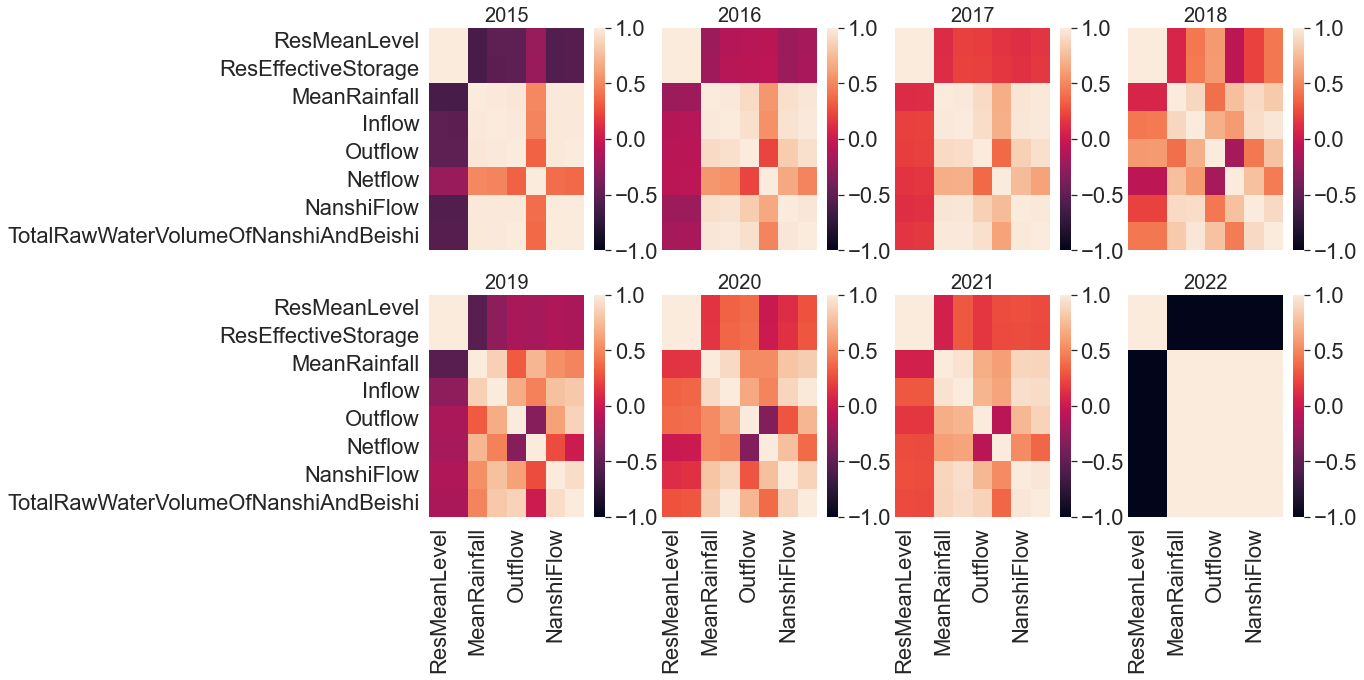

In [12]:
##繪製各年度月資料的heatmap

#設定畫布大小
plt.figure(figsize = (120, 9))
#設定x,y ticklabel and cxolor bar大小
sns.set(font_scale = 2)

for i in range(0, 8):
    
    if i == 0:
        plt.subplot(2, 4, int(i + 1)) #在2row4col空間中的第一張圖
        sns.heatmap(CorrList_Monthly[i], xticklabels = False, vmin = -1, vmax = 1)
        plt.gcf().set_size_inches(16, 9)
        plt.title( 2015 + int(i), fontsize = 20) # title with fontsize 20
    
    elif 0 < i < 4:
        plt.subplot(2, 4, int(i + 1)) #在2row4col空間中的第一張圖
        sns.heatmap(CorrList_Monthly[i], xticklabels = False, yticklabels=False, vmin = -1, vmax = 1)
        plt.gcf().set_size_inches(16, 9)
        plt.title( 2015 + int(i), fontsize = 20) # title with fontsize 20
    
    elif i == 4:
        plt.subplot(2, 4, int(i + 1)) #在2row4col空間中的第一張圖
        sns.heatmap(CorrList_Monthly[i], vmin = -1, vmax = 1)
        plt.gcf().set_size_inches(16, 9)
        plt.title( 2015 + int(i), fontsize = 20) # title with fontsize 20
    
    else:
        plt.subplot(2, 4, int(i + 1)) #在2row4col空間中的第一張圖
        sns.heatmap(CorrList_Monthly[i], yticklabels=False, vmin = -1, vmax = 1)
        plt.gcf().set_size_inches(16, 9)
        plt.title( 2015 + int(i), fontsize = 20) # title with fontsize 20


### 根據上圖，我們可以發現水庫水位在每個年度和其他變數的相關性並不存在一致性。

### 例如：以2015年與2021為例，在2015年水庫水位和其他變數呈現負相關，不過在2021年則為正相關。

### 其中的可能為水庫水位為存量，其餘變數皆為流量。不過此部分可以先由下方時間趨勢圖驗證過後再分析。

## Part 2：畫時間序列圖

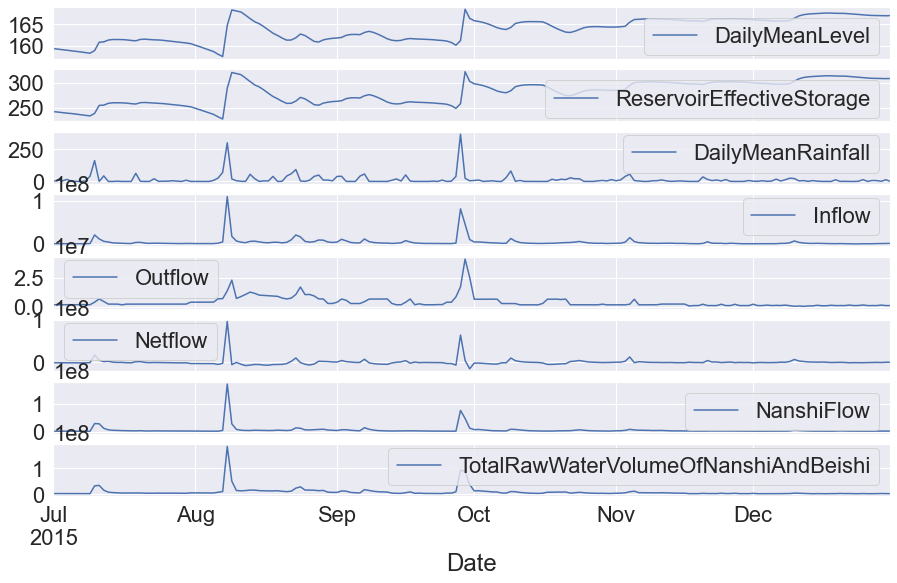

In [13]:
#2015年每日趨勢圖
Yearlist_Daily[0].plot(subplots=True, grid=True, style='b', figsize=(15,9))
plt.show()

#圖有點醜，希望可以重畫

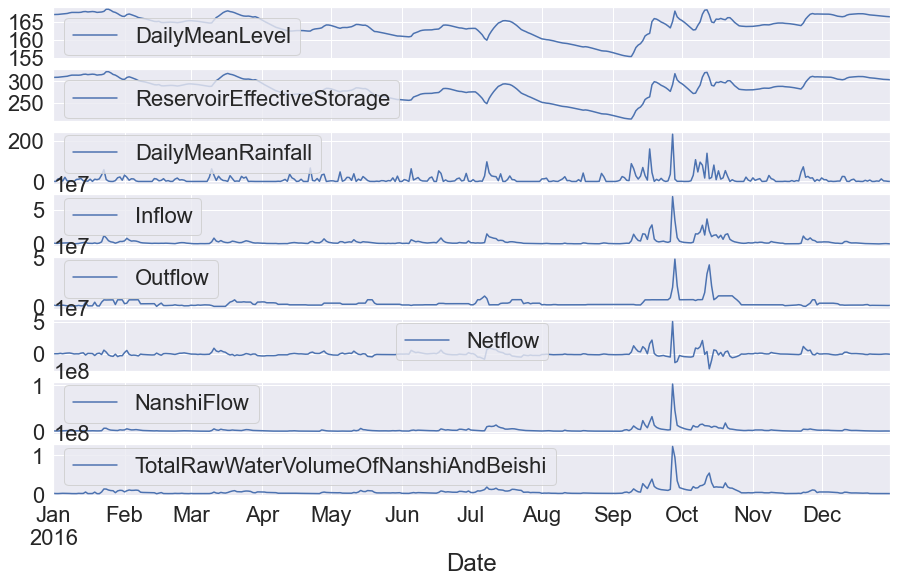

In [14]:
#2016年每日趨勢圖
Yearlist_Daily[1].plot(subplots=True, grid=True, style='b', figsize=(15,9))
plt.show()


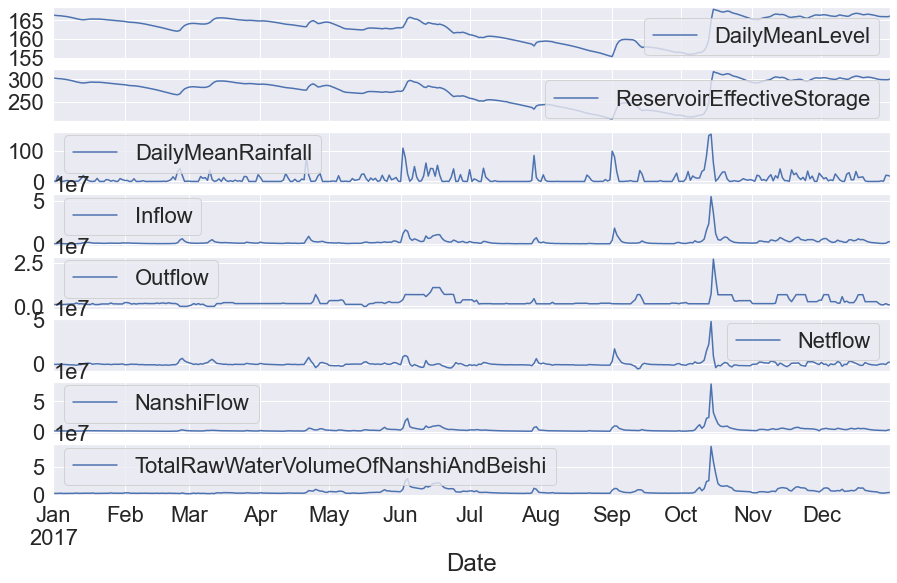

In [15]:
#2017年每日趨勢圖
Yearlist_Daily[2].plot(subplots=True, grid=True, style='b', figsize=(15,9))
plt.show()


## Question：以這個資料集而言，主要影響水庫水位的原因是甚麼?

### 由於水庫水位以及水庫有效蓄水量皆為存量，無法直接以時間趨勢圖看出與降雨量以及流進、流出量比較。因此先將水庫水位以及水庫有效蓄水量改為百分比變動率再進行繪圖。

In [16]:
#將水庫水位以及水庫有效蓄水量改為百分比變動率
reservoir_Daily["gr_DailyMeanLevel"] = reservoir_Daily["DailyMeanLevel"].pct_change().dropna()*100
reservoir_Daily["gr_ReservoirEffectiveStorage"] = reservoir_Daily["ReservoirEffectiveStorage"].pct_change().dropna()*100

In [17]:
"""
新創一個df：gr_reservoir_Daily
先刪去DailyMeanLevel、ReservoirEffectiveStorage這兩欄
再reservoir_Daily這個dataframe的growth rate移至最前
以利畫圖
"""
gr_reservoir_Daily = reservoir_Daily.drop(columns = ["DailyMeanLevel", "ReservoirEffectiveStorage"])

temp_cols = gr_reservoir_Daily.columns.tolist()
new_cols = temp_cols[-2:] + temp_cols[:-2]
gr_reservoir_Daily = gr_reservoir_Daily[new_cols]

In [18]:
##取出各年度含百分比變動率的日資料

#創立List當中的空間
gr_Yearlist_Daily = []
gr_CorrList_Daily = []

for year in range(2015, 2023):
    gr_Yearlist_Daily = gr_Yearlist_Daily + ["reservoir_Daily_" + str(year)]
    gr_CorrList_Daily = gr_CorrList_Daily + ["reservoir_Daily_" + str(year)]
    
#取出個年度的每月資料
for i, year in zip(range(0, 9), range(2015, 2023)):
    gr_Yearlist_Daily[i] = gr_reservoir_Daily[(gr_reservoir_Daily.year == year)].drop(columns = "year")
    gr_CorrList_Daily[i] = gr_Yearlist_Daily[i].corr()
    
    
#Yearlist_Daily[0]、CorrList_Monthly[0]: 2015的資料
#...
#Yearlist_Daily[7]、CorrList_Monthly[7]：2022的資料

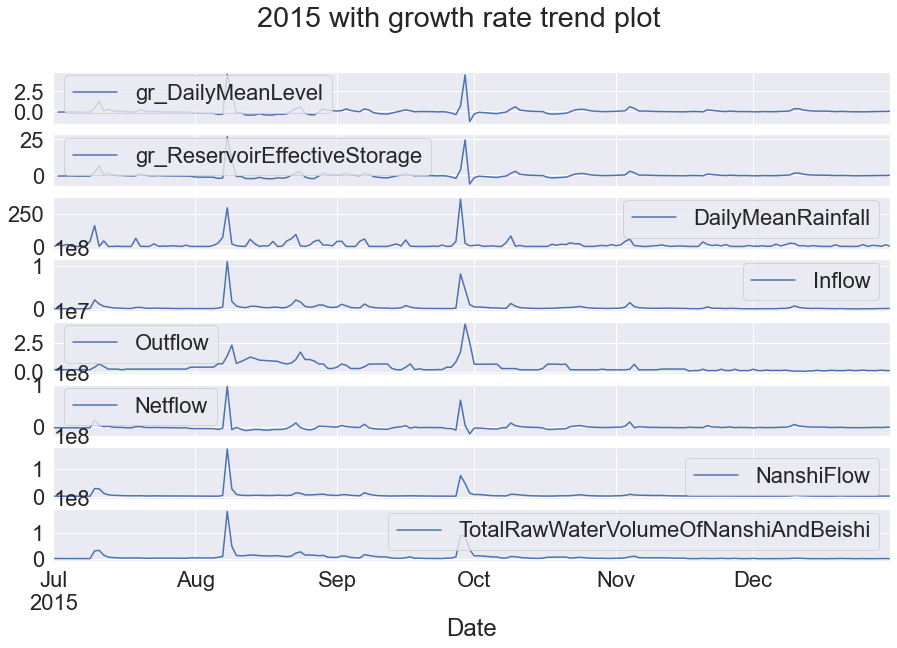

In [19]:
#2015年含百分比變動率每日趨勢圖
gr_Yearlist_Daily[0].plot(subplots=True, grid=True, style='b', figsize=(15,9), title= "2015 with growth rate trend plot")
plt.show()

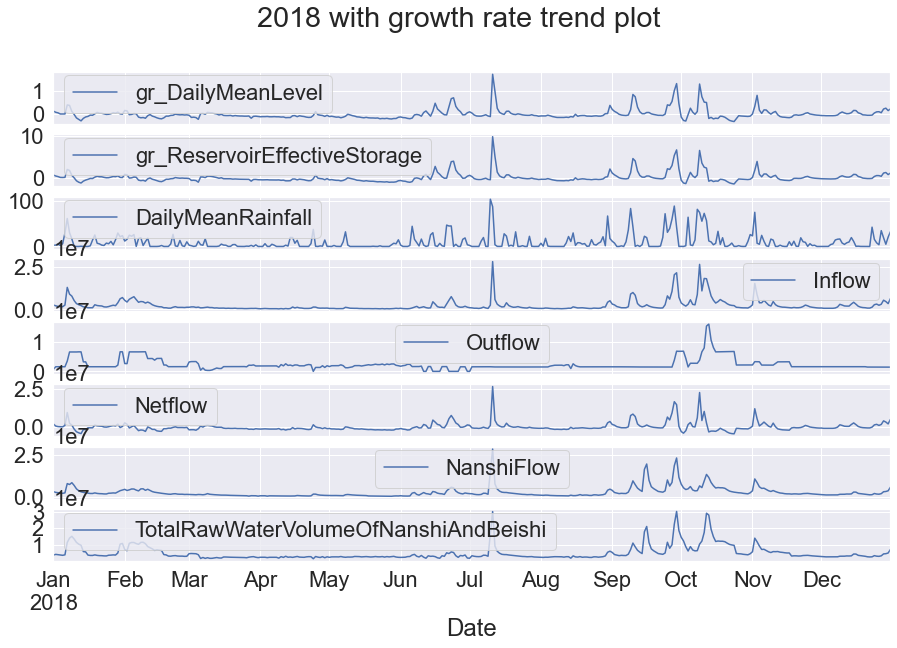

In [20]:
#2018年含百分比變動率每日趨勢圖
gr_Yearlist_Daily[3].plot(subplots=True, grid=True, style='b', figsize=(15,9), title= "2018 with growth rate trend plot")
plt.show()

###  根據含有百分比變動率的時間趨勢圖發現其實水庫水位的變化量與雨量以及水庫的流入流出量趨勢一致。

### 因此再使用含有百分比變動率的資料繪製heatmap以證上方的說法。

## Part 3：再繪製heatmap

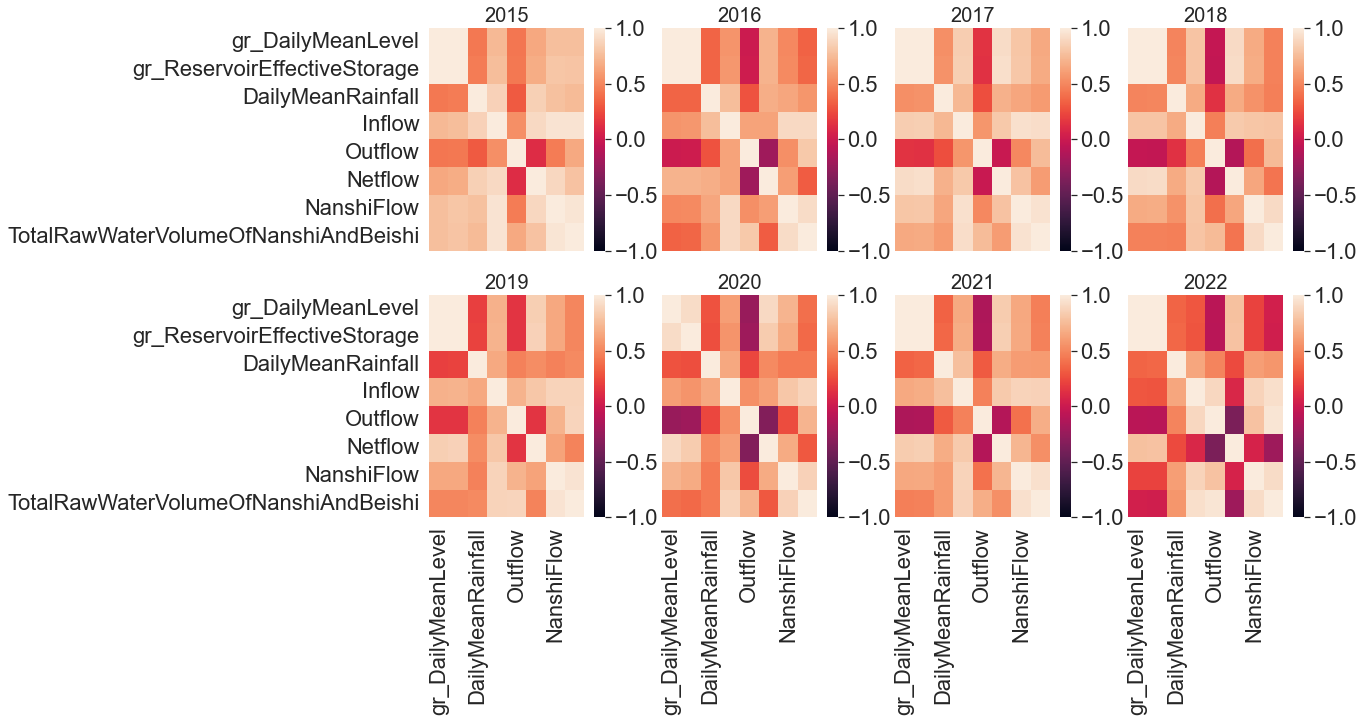

In [21]:
##繪製各年度日資料含有百分比變動率的heatmap

#設定畫布大小
plt.figure(figsize = (120, 9))
#設定x,y ticklabel and cxolor bar大小
sns.set(font_scale = 2)

for i in range(0, 8):
    
    if i == 0:
        plt.subplot(2, 4, int(i + 1)) #在2row4col空間中的第一張圖
        sns.heatmap(gr_CorrList_Daily[i], xticklabels = False, vmin = -1, vmax = 1)
        plt.gcf().set_size_inches(16, 9)
        plt.title( 2015 + int(i), fontsize = 20) # title with fontsize 20
    
    elif 0 < i < 4:
        plt.subplot(2, 4, int(i + 1)) #在2row4col空間中的第一張圖
        sns.heatmap(gr_CorrList_Daily[i], xticklabels = False, yticklabels=False, vmin = -1, vmax = 1)
        plt.gcf().set_size_inches(16, 9)
        plt.title( 2015 + int(i), fontsize = 20) # title with fontsize 20
    
    elif i == 4:
        plt.subplot(2, 4, int(i + 1)) #在2row4col空間中的第一張圖
        sns.heatmap(gr_CorrList_Daily[i], vmin = -1, vmax = 1)
        plt.gcf().set_size_inches(16, 9)
        plt.title( 2015 + int(i), fontsize = 20) # title with fontsize 20
    
    else:
        plt.subplot(2, 4, int(i + 1)) #在2row4col空間中的第一張圖
        sns.heatmap(gr_CorrList_Daily[i], yticklabels=False, vmin = -1, vmax = 1)
        plt.gcf().set_size_inches(16, 9)
        plt.title( 2015 + int(i), fontsize = 20) # title with fontsize 20


###  此時，得出了較為一致的結論：水庫的流出量與水庫平均水位的變動率呈現負相關

### 不過依照此資料集如果需要正確釐清主要影響水庫水位的原因的話還需要思考是否需要納入其他未觀察到的變數。
### 下方再透過月資料驗證一次。

In [22]:
reservoir_Monthly.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 80 entries, 2015-07 to 2022-02
Freq: M
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ResMeanLevel                          80 non-null     float64
 1   ResEffectiveStorage                   80 non-null     float64
 2   MeanRainfall                          80 non-null     float64
 3   Inflow                                80 non-null     float64
 4   Outflow                               80 non-null     float64
 5   Netflow                               80 non-null     float64
 6   NanshiFlow                            80 non-null     float64
 7   TotalRawWaterVolumeOfNanshiAndBeishi  80 non-null     float64
 8   year                                  80 non-null     int32  
dtypes: float64(8), int32(1)
memory usage: 5.9 KB


In [23]:
#將水庫水位以及水庫有效蓄水量的月資料改為百分比變動率
reservoir_Monthly["gr_ResMeanLevel"] = reservoir_Monthly["ResMeanLevel"].pct_change().dropna()*100
reservoir_Monthly["gr_ResEffectiveStorage"] = reservoir_Monthly["ResEffectiveStorage"].pct_change().dropna()*100


In [24]:
"""
新創一個df：gr_reservoir_Monthly
先刪去ResMeanLevel、ResEffectiveStorage這兩欄
再reservoir_Daily這個dataframe的growth rate移至最前
以利畫圖
"""
gr_reservoir_Monthly = reservoir_Monthly.drop(columns = ["ResMeanLevel", "ResEffectiveStorage"])

temp_cols = gr_reservoir_Monthly.columns.tolist()
new_cols = temp_cols[-2:] + temp_cols[:-2]
gr_reservoir_Monthly = gr_reservoir_Monthly[new_cols]

In [25]:
##取出各年度含百分比變動率的月資料

#創立List當中的空間
gr_Yearlist_Monthly = []
gr_CorrList_Monthly = []

for year in range(2015, 2023):
    gr_Yearlist_Monthly = gr_Yearlist_Monthly + ["reservoir_Monthly_" + str(year)]
    gr_CorrList_Monthly = gr_CorrList_Monthly + ["reservoir_Monthly_" + str(year)]
    
#取出個年度的每月資料
for i, year in zip(range(0, 9), range(2015, 2023)):
    gr_Yearlist_Monthly[i] = gr_reservoir_Monthly[(gr_reservoir_Monthly.year == year)].drop(columns = "year")
    gr_CorrList_Monthly[i] = gr_Yearlist_Monthly[i].corr()
    
    
#Yearlist_Daily[0]、CorrList_Monthly[0]: 2015的資料
#...
#Yearlist_Daily[7]、CorrList_Monthly[7]：2022的資料

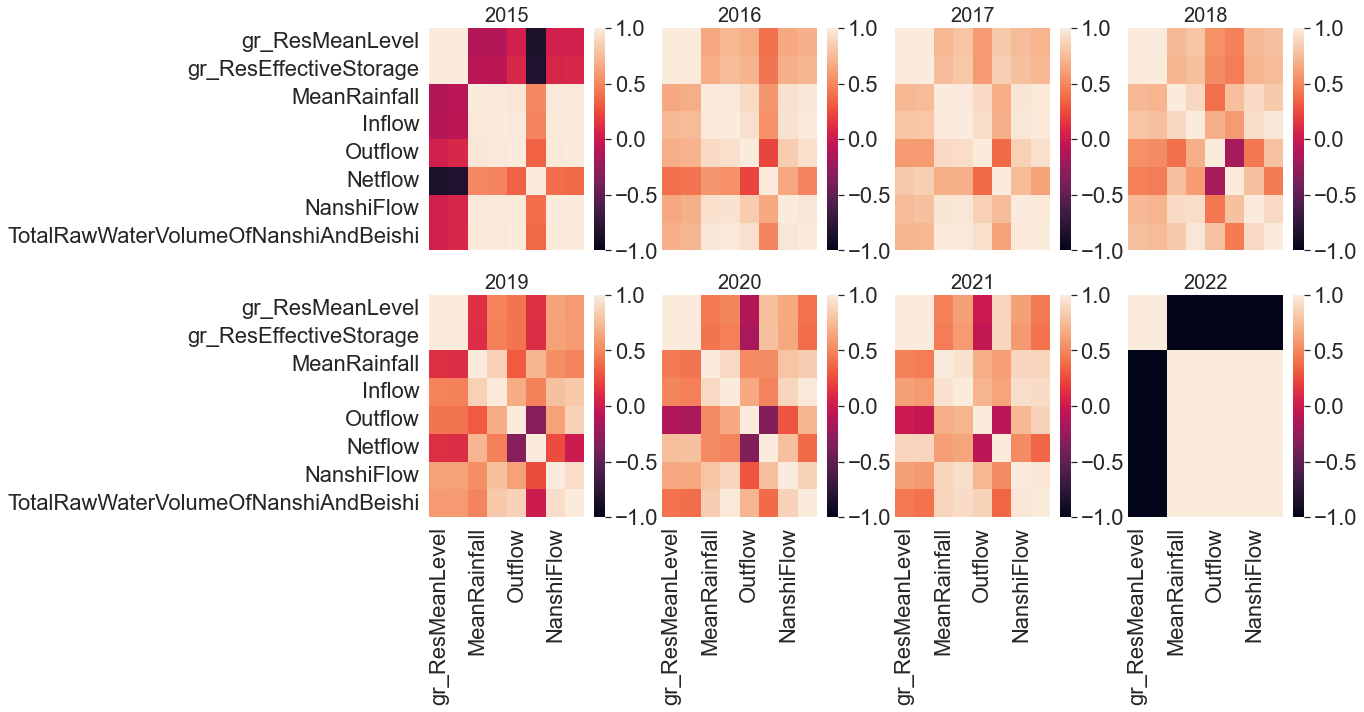

In [26]:
##繪製各年度月資料含有百分比變動率的heatmap

#設定畫布大小
plt.figure(figsize = (120, 9))
#設定x,y ticklabel and cxolor bar大小
sns.set(font_scale = 2)

for i in range(0, 8):
    
    if i == 0:
        plt.subplot(2, 4, int(i + 1)) #在2row4col空間中的第一張圖
        sns.heatmap(gr_CorrList_Monthly[i], xticklabels = False, vmin = -1, vmax = 1)
        plt.gcf().set_size_inches(16, 9)
        plt.title( 2015 + int(i), fontsize = 20) # title with fontsize 20
    
    elif 0 < i < 4:
        plt.subplot(2, 4, int(i + 1)) #在2row4col空間中的第一張圖
        sns.heatmap(gr_CorrList_Monthly[i], xticklabels = False, yticklabels=False, vmin = -1, vmax = 1)
        plt.gcf().set_size_inches(16, 9)
        plt.title( 2015 + int(i), fontsize = 20) # title with fontsize 20
    
    elif i == 4:
        plt.subplot(2, 4, int(i + 1)) #在2row4col空間中的第一張圖
        sns.heatmap(gr_CorrList_Monthly[i], vmin = -1, vmax = 1)
        plt.gcf().set_size_inches(16, 9)
        plt.title( 2015 + int(i), fontsize = 20) # title with fontsize 20
    
    else:
        plt.subplot(2, 4, int(i + 1)) #在2row4col空間中的第一張圖
        sns.heatmap(gr_CorrList_Monthly[i], yticklabels=False, vmin = -1, vmax = 1)
        plt.gcf().set_size_inches(16, 9)
        plt.title( 2015 + int(i), fontsize = 20) # title with fontsize 20

###  上圖月資料的結論與日資料一致。

# 模型預測

## 方法一：使用現有套件選擇ARIMA模型參數

In [27]:
from pmdarima import auto_arima

In [28]:
#https://www.kaggle.com/code/sadeght/arima-sarima-simple-clear-analysis/notebook
stepwise_model = auto_arima(reservoir_Monthly["ResMeanLevel"], start_p = 1, start_q = 1,
                           max_p = 3, max_q = 4, m=12,
                           start_P=0, seasonal=True,
                           d = 1, D = 1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
#d: order of difference level
#D: order of seasonal difference level

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=366.855, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=349.134, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=368.731, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=341.665, Time=0.09 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=341.680, Time=0.23 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=339.810, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=347.283, Time=0.03 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=339.827, Time=0.20 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=341.614, Time=0.10 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=337.072, Time=0.24 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=343.50

### 得出模型參數，進行Train Test Split

In [29]:
test = reservoir_Monthly["ResMeanLevel"].loc["2021-01-01":]
train = reservoir_Monthly["ResMeanLevel"].loc[:"2020-12-01"]

stepwise_model.fit(train)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [30]:
future_forecast = stepwise_model.predict(n_periods = 14)
print(future_forecast)

#2021-01 to 2022-02:14 periods

[166.8951126  164.58116111 161.75174784 157.9971979  154.47533137
 151.9266144  154.86727477 153.64130366 154.65548235 161.29497479
 163.16062545 164.03559142 164.75406397 162.49793397]


<AxesSubplot:xlabel='Date'>

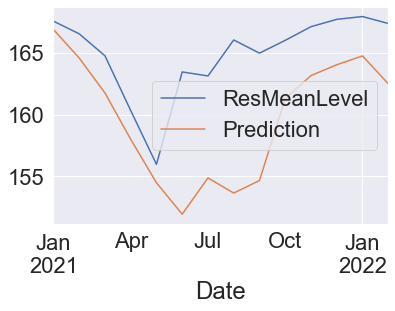

In [31]:
future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Prediction'])

pd.concat([test, future_forecast], axis=1).plot()


MSE score:  40.58403494506765


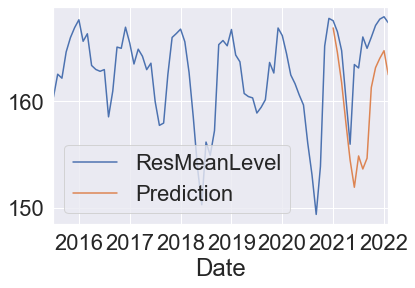

In [32]:
pd.concat([reservoir_Monthly["ResMeanLevel"],future_forecast],axis=1).plot();

from sklearn import metrics
mse = metrics.mean_squared_error(test, future_forecast['Prediction'])
print('MSE score: ', mse)

> 使用套件選擇參數的模型MSE score:  40.5840

## 方法二：使用計量時間序列方式選擇ARIMA模型參數

### 下方模型會以月資料為主，因為日資料建立模型時電腦資源不足。

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.tsa.stattools as ts

In [34]:
def adf_test(series):
    result = ts.adfuller(series)
    print("===============================================================================")
    print("test-statistics：" + str(np.round(result[0], 6)))
    print("===============================================================================")
    print("5% critical value of test statistics：" + str(np.round(result[4]["5%"], 6)))
    print("===============================================================================")
    if result[1] <= 0.05:
        print("此結論拒絕序列資料為單根的虛無假設；故此序列為定態，不具單根。")
    else:
        print("此結論無法拒絕序列資料為單根的虛無假設；故此序列非定態，具單根。")
    


##  Step 1：檢驗資料是否定態

In [35]:
adf_test(reservoir_Monthly["ResMeanLevel"])

test-statistics：-4.948669
5% critical value of test statistics：-2.900395
此結論拒絕序列資料為單根的虛無假設；故此序列為定態，不具單根。


###  根據上方檢定，資料為定態，因此可以直接使用資料原水準進行建立模型的步驟

## Step 2：選擇模型參數

## Step 2-1：選擇非季節性參數

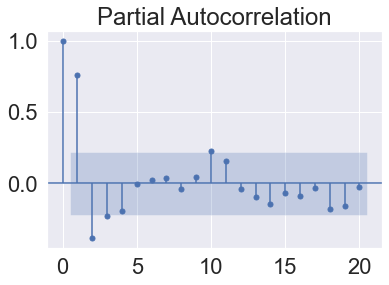

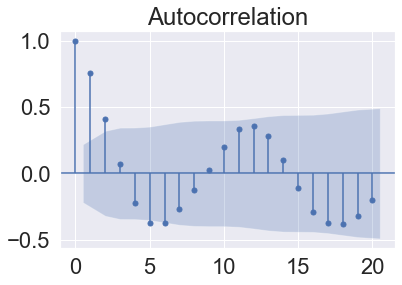

In [36]:
plot_pacf(reservoir_Monthly["ResMeanLevel"])
plot_acf(reservoir_Monthly["ResMeanLevel"]);

### 根據上方： PACF: AR(p), p = 2; ACF: MA(q), q = 6; Integrated order: d = 0
order = (p, d, q)：order = (2, 0, 6)

In [37]:
#一階差分
reservoir_Monthly["ResMeanLevel first Difference"] = reservoir_Monthly["ResMeanLevel"] - reservoir_Monthly["ResMeanLevel"].shift(1)

## Step 2-2：選擇季節性參數
### 由於雨量及水庫是每年一循環，因此下方設定為12期；所以下方以12階的差分進行繪圖以及ADF 檢定。

In [38]:
#365階差分
reservoir_Monthly["ResMeanLevel 12 Difference"] = reservoir_Monthly["ResMeanLevel"] - reservoir_Monthly["ResMeanLevel"].shift(12)

In [39]:
adf_test(reservoir_Monthly["ResMeanLevel 12 Difference"].dropna())

test-statistics：-3.91055
5% critical value of test statistics：-2.914731
此結論拒絕序列資料為單根的虛無假設；故此序列為定態，不具單根。


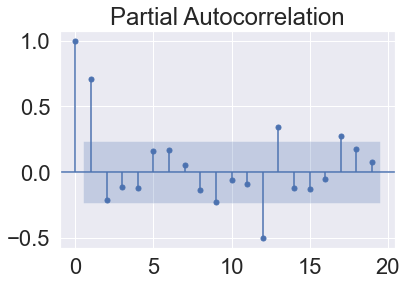

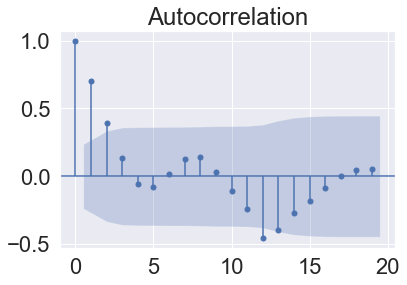

In [40]:
#再透過圖示確認是否有單根
#因進行差分，故會產生缺失值，因此使愈dropna
plot_pacf(reservoir_Monthly["ResMeanLevel 12 Difference"].dropna())
plot_acf(reservoir_Monthly["ResMeanLevel 12 Difference"].dropna());

## 根據上方： 
#### PACF: AR(p), p = 1, 12, 13 -> 1
#### Integrated order: d = 0
#### ACF: MA(q), q = 2, 12 -> 2
#### Seasonal periodicity: 12
(Seasonal AR(p), Seasonal Integration order, Seasonal MA(q), Seasonal periodicity)

seasonal_order = (1, 0, 2, 12)

## Step 3：進行樣本內、樣本外模型訓練


In [41]:
#先設置樣本內、樣本外時間

from datetime import datetime, timedelta
train_dataset_end = datetime(2020,12,1)
test_dataset_end = datetime(2021,12,1)

#分樣本
train_data = reservoir_Monthly[:train_dataset_end]
test_data = reservoir_Monthly[train_dataset_end+timedelta(days = 1):test_dataset_end]

In [42]:
#prediction period
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

2020-12
2021-12


In [43]:
model = SARIMAX(train_data["ResMeanLevel"], order = (2, 0, 6), seasonal_order = (1, 0, 2, 12))

In [44]:
model_fit = model.fit()

C:\Users\hughw\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                            ResMeanLevel   No. Observations:                   66
Model:             SARIMAX(2, 0, 6)x(1, 0, [1, 2], 12)   Log Likelihood                -152.725
Date:                                 Tue, 13 Dec 2022   AIC                            329.450
Time:                                         11:35:34   BIC                            355.726
Sample:                                     07-31-2015   HQIC                           339.833
                                          - 12-31-2020                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0127      0.735      0.017      0.986      -1.428       1.453
ar.L2          0.9873      0.735      1.344      0.179      -0.452       2.427
ma.L1          1.0956      0.336      3.258      0.001       0.436       1.755
ma.L2         -0.0803      0.201     -0.400      0.689      -0.474       0.313
ma.L3         -0.2651      0.189     -1.401      0.161      -0.636       0.106
ma.L4         -0.4492      0.211     -2.133      0.033      -0.862      -0.036
ma.L5         -0.7899      0.269     -2.932      0.003      -1.318      -0.262
ma.L6         -0.4281      0.197     -2.170      0.030      -0.815      -0.041
ar.S.L12       0.9925      0.173      5.752      0.000       0.654       1.331
ma.S.L12      -1.7487      5.916     -0.296      0.768     -13.344       9.847
ma.S.L24       0.8725      5.013      0.174      0.862      -8.954      10.698
sigma2         2.6334     15.715      0.168      0.867     -28.168      33.435
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 3.28
Prob(Q):                              0.70   Prob(JB):                         0.19
Heteroskedasticity (H):               2.37   Skew:                             0.07
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
fitted_value = model_fit.predict(start = datetime(2020, 12, 1), end = datetime(2021, 12, 1))
residuals = test_data["ResMeanLevel"] - fitted_value
#區間參考 prediction period

In [47]:
test_data["fitted_value"] = fitted_value

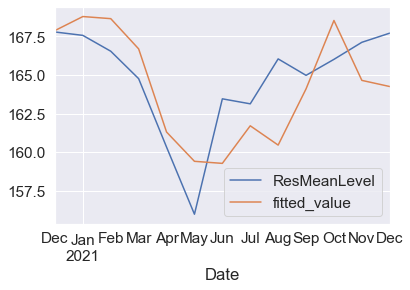

In [48]:
sns.set(font_scale = 1.4)
test_data[["ResMeanLevel", "fitted_value"]].plot();

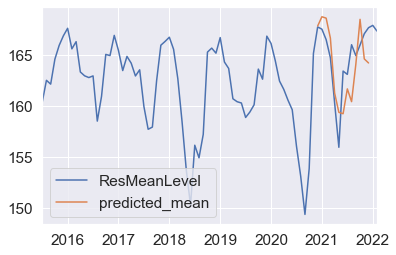

In [49]:
pd.concat([reservoir_Monthly["ResMeanLevel"],fitted_value],axis=1).plot();

In [50]:
from sklearn import metrics
mse = metrics.mean_squared_error(test_data["ResMeanLevel"], test_data["fitted_value"])
print('MSE score: ', mse)

MSE score:  7.577259392773448


###  得出使用autocorrelation以及partial autocorrelation函數並透過計量方法選擇的參數模型表現優於機器選擇的參數模型


### 而透過autocorrelation function選擇參數的方式亦可推廣至LSTM模型中選擇其rolling window length，因為LSTM就是一個 generalized AR model in NN frame work.